# 2.0 Exploratory Data Analysis

## Set up

In [1]:
from cell_viewer.utils.paths import here

%run {here("notebooks", "0.2-jvs-before_to_start.ipynb")}

## Libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import numpy as np
import janitor

plt.style.use("seaborn-white")
sns.set_style("whitegrid")


## Load data

### Data file

In [3]:
processed_lineages_file = data_processed_dir("processed_lineages.tsv")
processed_lineages_file.exists()

True

### Read

In [4]:
processed_lineages_df = pd.read_csv(processed_lineages_file, sep="\t")
processed_lineages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330067 entries, 0 to 330066
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   lineage_id                       330067 non-null  int64  
 1   track_id                         330067 non-null  object 
 2   cell_id                          330067 non-null  float64
 3   mother_id                        330067 non-null  float64
 4   frame                            330067 non-null  int64  
 5   roi_id                           330067 non-null  object 
 6   length                           330067 non-null  float64
 7   division                         330067 non-null  int64  
 8   tracking_score                   164490 non-null  float64
 9   gfp                              330067 non-null  float64
 10  ds_red                           330067 non-null  float64
 11  experiment_id                    330067 non-null  object 
 12  tr

## EDA

### Fluorescent intensity

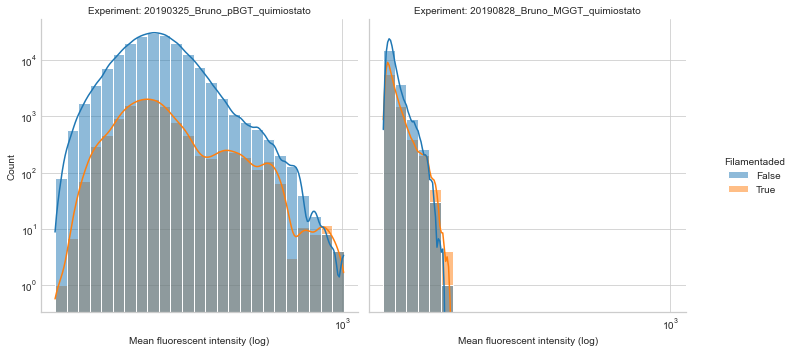

In [5]:
fluorescent_intensity_p = (
    processed_lineages_df
    .groupby(["experiment_id", "trap_id", "cell_id"])
    .aggregate({
        "filamentaded_cell": lambda filamentaded_cell: filamentaded_cell.unique(),
        "gfp": "mean"
    })
    .reset_index()
    .pipe(
        lambda df: sns.displot(
            data=df,
            x="gfp",
            hue="filamentaded_cell",
            #row="filamentaded_cell",
            col="experiment_id",
            log_scale=True,
            legend=True,
            facet_kws=dict(
                # sharex=False,
                # sharey=False
            ),
            bins = 25,
            kde=True
        )
    )
)

(
    fluorescent_intensity_p
    .set_axis_labels("Mean fluorescent intensity (log)", "Count")
    .set_titles("Experiment: {col_name}")
    .legend.set_title("Filamentaded")
)

plt.yscale("log")

### Proportion of cells over time

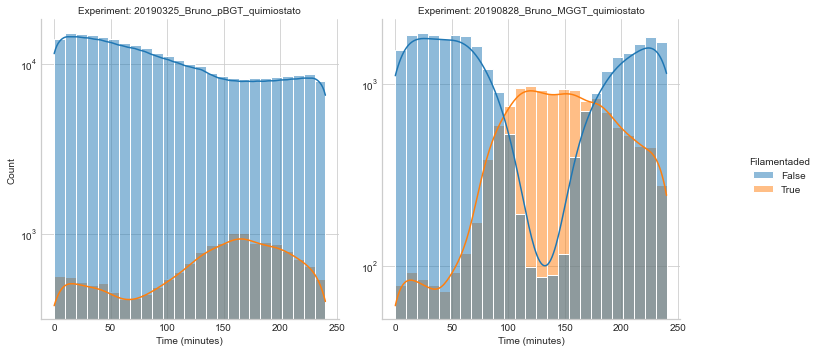

In [6]:
proportion_cells_time_p = (
    processed_lineages_df
    .pipe(
        lambda df: sns.displot(
            data=df,
            x="time",
            hue="filamentaded_at_frame",
            col="experiment_id",
            kind="hist",
            stat="count",
            discrete=False,
            kde=True,
            bins=df.centered_frame.max() + 1,
            facet_kws=dict(
                sharey=False
            )
        )
    )
)

(
    proportion_cells_time_p
    .set_axis_labels("Time (minutes)", "Count")
    .set_titles("Experiment: {col_name}")
    .legend.set_title("Filamentaded")
)

proportion_cells_time_p.set(yscale="log")

### Compare between before and after filamentation

In [7]:
results = (
    processed_lineages_df
    .filter_on("filamentaded_track")
    .sort_values(by=["experiment_id", "trap_id", "track_id", "centered_frame"])
    .groupby(["experiment_id", "trap_id", "track_id"])
    .apply(lambda df: {
        "min_position": df.filamentaded_at_frame.argmin(),
        "max_position": df.filamentaded_at_frame.argmax(),
        "filamentation_frame": df.centered_frame.iloc[df.filamentaded_at_frame.argmax()],
        "initial_gfp": df.gfp.iloc[df.filamentaded_at_frame.argmin()],
        "sos_gfp": df.gfp.iloc[df.filamentaded_at_frame.argmax()],
        "end_gfp": df.gfp.iloc[-1, ],
        "initial_length": df.length.iloc[df.filamentaded_at_frame.argmin()],
        "sos_length": df.length.iloc[df.filamentaded_at_frame.argmax()],
        "end_length": df.length.iloc[-1, ],
        "frames_lived": df.centered_frame.iloc[-1] - df.centered_frame.iloc[0]
    })
    .reset_index()
    .rename_column(0, "metrics")
    .pipe(lambda df: pd.concat([df, pd.json_normalize(df.metrics)], axis=1))
    .drop(columns="metrics")
    .assign(time_lived=lambda df: df.frames_lived * 10)
)

results

,experiment_id,trap_id,track_id,min_position,max_position,filamentation_frame,initial_gfp,sos_gfp,end_gfp,initial_length,sos_length,end_length,frames_lived,time_lived
0,20190325_Bruno_pBGT_quimiostato,xy01,20.032-35.002,1,0,0,194.952,194.050,187.486,32.672211,63.893864,44.696067,15,150
1,20190325_Bruno_pBGT_quimiostato,xy01,20.032-41.001,1,0,0,187.814,194.050,160.468,35.484978,63.893864,41.286148,21,210
2,20190325_Bruno_pBGT_quimiostato,xy01,20.32-35.2,1,0,0,194.952,194.050,187.486,32.672132,63.893846,44.696067,15,150
3,20190325_Bruno_pBGT_quimiostato,xy01,20.32-41.1,1,0,0,187.814,194.050,160.468,35.484976,63.893846,41.286149,21,210
4,20190325_Bruno_pBGT_quimiostato,xy02,20.001-24.001,0,0,0,409.621,409.621,470.870,83.763866,83.763866,60.736747,4,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6791,20190828_Bruno_MGGT_quimiostato,xy13,32.030-33.041,0,1,23,120.028,120.557,120.557,34.799892,44.139244,44.139244,1,10
6792,20190828_Bruno_MGGT_quimiostato,xy13,32.031-33.040,0,1,23,120.775,120.259,120.259,32.028231,44.599964,44.599964,1,10
6793,20190828_Bruno_MGGT_quimiostato,xy13,32.031-34.040,0,2,24,120.775,121.864,121.864,32.028231,52.245440,52.245440,2,20
6794,20190828_Bruno_MGGT_quimiostato,xy13,33.028-34.028,1,0,23,119.724,118.628,119.724,34.976596,74.830869,34.976596,1,10


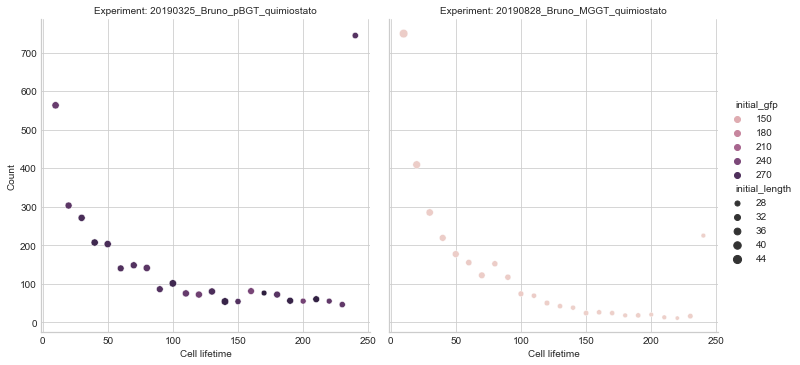

In [8]:
frames_lived_full_p = (
    results
    .select_columns(["experiment_id","time_lived", "initial_gfp", "initial_length"])
    .groupby(["experiment_id", "time_lived"])
    .pipe(
        lambda df: (
            df
            .size()
            .reset_index()
            .rename_column(0, "n")
            .merge(
                df.aggregate("mean"),
                on=["experiment_id", "time_lived"]
            )
        )
    )
    .pipe(lambda df: sns.relplot(
        data=df,
        x="time_lived",
        y="n",
        size="initial_length",
        hue="initial_gfp",
        col="experiment_id"
    ))
)

(
    frames_lived_full_p
    .set_axis_labels("Cell lifetime", "Count")
    .set_titles("Experiment: {col_name}")
)

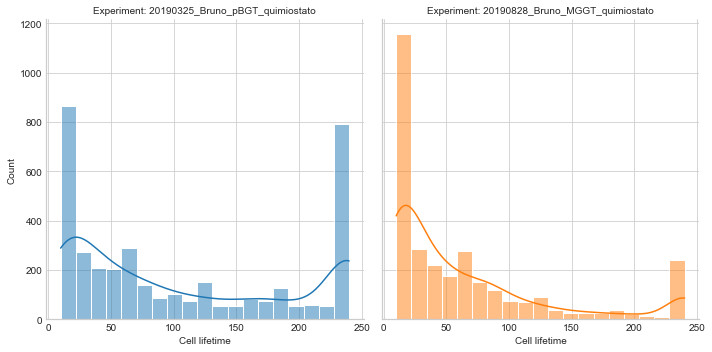

In [9]:
frames_lived_p = sns.displot(
    data=results,
    x="time_lived",
    hue="experiment_id",
    col="experiment_id",
    kde=True,
    legend=False
)

(
    frames_lived_p
    .set_axis_labels("Cell lifetime", "Count")
    .set_titles("Experiment: {col_name}")
)

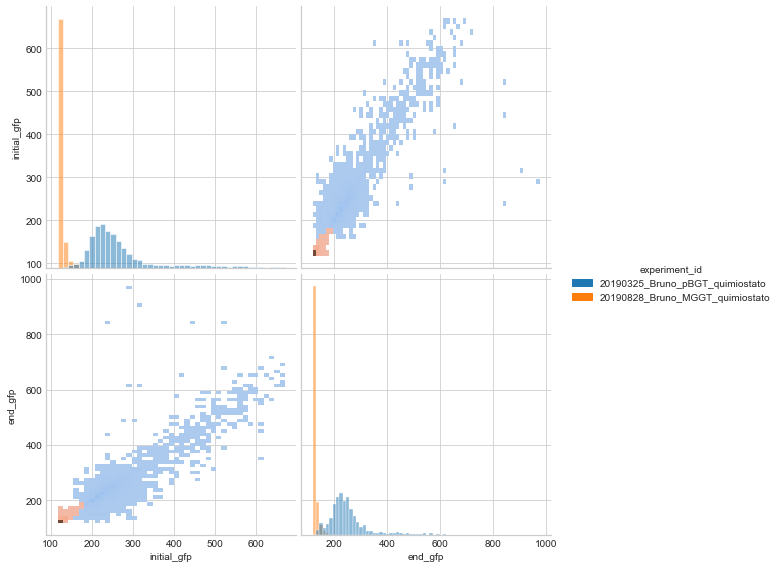

In [10]:
pairplot_metrics_p = (
    results
    .select_columns(["experiment_id", "initial_gfp", "end_gfp"])
    .pipe(
        lambda df:
            sns.pairplot(data=df, hue="experiment_id", kind="hist", height=4)
    )
)

pairplot_metrics_p

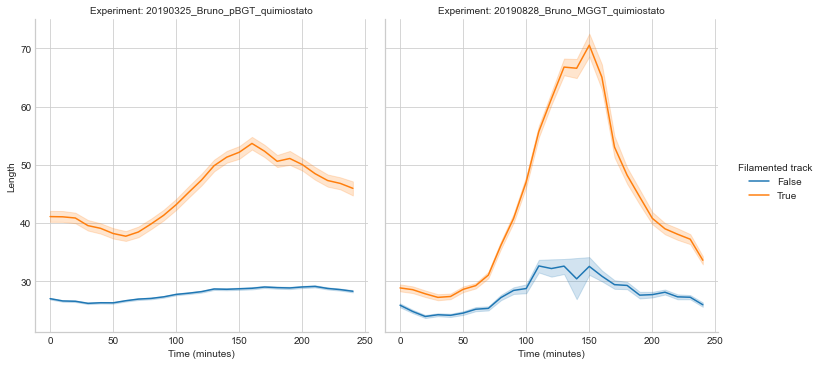

In [11]:
length_time_p = (
    processed_lineages_df
    .pipe(
        lambda df: sns.relplot(
            data=df,
            x="time",
            y="length",
            hue="filamentaded_track",
            col="experiment_id",
            kind="line"
        )
    )
)

(
    length_time_p
    .set_axis_labels("Time (minutes)", "Length")
    .set_titles("Experiment: {col_name}")
    ._legend.set_title("Filamented track")
)

In [12]:
n_bins=20

gfp_control = (
    processed_lineages_df
    .filter_on("experiment_id == '20190325_Bruno_pBGT_quimiostato'")
    .assign(gfp=lambda df: np.log10(df.gfp))
    .gfp
)

gfp_filamentaded, gfp_not_filamentaded = (
    processed_lineages_df
    .filter_on("experiment_id == '20190325_Bruno_pBGT_quimiostato'")
    .assign(gfp=lambda df: np.log10(df.gfp))
    .select_columns(["lineage_id", "trap_id", "track_id", "centered_frame", "centered_antibiotic_start_frame", "centered_antibiotic_end_frame", "gfp", "filamentaded_track"])
    .groupby(["lineage_id", "trap_id", "track_id", "filamentaded_track"])
    .aggregate(list)
    .assign(
        centered_frame=lambda df: df.centered_frame.apply(np.array),
        centered_antibiotic_start_frame=lambda df: df.centered_antibiotic_start_frame.apply(lambda s: s[0]),
        centered_antibiotic_end_frame=lambda df: df.centered_antibiotic_end_frame.apply(lambda s: s[0]),
        gfp=lambda df: df.gfp.apply(lambda s: s[0]),
        is_long_track=lambda df: df.apply(
            lambda row: 
                row.centered_frame[0] < row.centered_antibiotic_start_frame and
                row.centered_frame[-1] > row.centered_antibiotic_end_frame,
            axis=1 
        )
    )
    .reset_index()
    .filter_on("is_long_track")
    .select_columns(["filamentaded_track", "gfp"])
    .groupby("filamentaded_track")
    .pipe(lambda df: [df.get_group(True).gfp, df.get_group(False).gfp])
)

gfp_control.iloc[0], gfp_filamentaded.iloc[0], gfp_not_filamentaded.iloc[0]

(2.3065772720141564, 2.764603489085131, 2.3065772720141564)

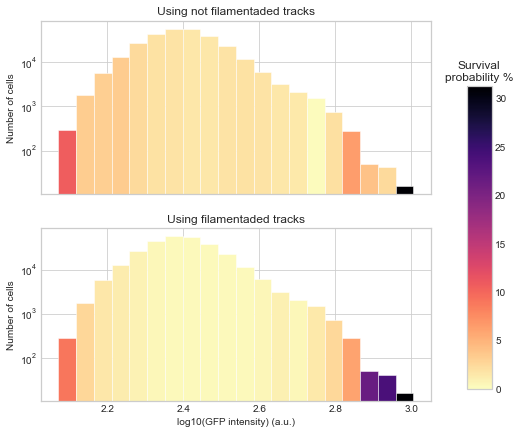

In [13]:
# Set figures layout.
fig, (ax_1, ax_2) = plt.subplots(2, sharex=True, sharey=True, figsize=(7,7))

# Draw default histogram.
n_plasmid0, bins_plasmid0, patches_plasmid_not_filamentaded = ax_1.hist(gfp_control, bins=n_bins, linewidth=0.5)
n_plasmid0, bins_plasmid0, patches_plasmid_filamentaded = ax_2.hist(gfp_control, bins=n_bins, linewidth=0.5)

# Calculate bins for not filamenteded and filamentaded.
n_not_filamentaded, _= np.histogram(gfp_not_filamentaded, bins=n_bins)
n_filamentaded, _ = np.histogram(gfp_filamentaded, bins=n_bins)

# Calculate survival probability
survival_probability_not_filamentaded = n_not_filamentaded.astype(int) / n_plasmid0.astype(int)
survival_probability_filamentaded = n_filamentaded.astype(int) / n_plasmid0.astype(int)
max_not_filamentaded = survival_probability_not_filamentaded.max()
max_filamentaded = survival_probability_filamentaded.max()
max_all = max(max_not_filamentaded, max_filamentaded)

survival_probability_filamentaded /= max_all
survival_probability_not_filamentaded /= max_all


cmap = plt.cm.magma_r

for i in range(n_bins):
    patches_plasmid_not_filamentaded[i].set_facecolor(
        cmap(survival_probability_not_filamentaded[i])
    )

    patches_plasmid_filamentaded[i].set_facecolor(
        cmap(survival_probability_filamentaded[i])
    )

plt.yscale("log")
norm = mpl.colors.Normalize(vmin=0, vmax=max_all*100)
color_bar_ax = fig.add_axes([.97, 0.15, 0.05, 0.6])
mpl.colorbar.ColorbarBase(color_bar_ax, cmap=cmap, norm=norm)
color_bar_ax.set_label("Survival probability")

# Set titles

ax_1.set_title("Using not filamentaded tracks")
ax_2.set_title("Using filamentaded tracks");
ax_2.set_xlabel("log10(GFP intensity) (a.u.)")
ax_1.set_ylabel("Number of cells")
ax_2.set_ylabel("Number of cells")
color_bar_ax.set_title("Survival\nprobability %");